### Goal : Plot MAPE*training size
--

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tuxml

In [2]:
features = tuxml.load_dataset()
selection = pd.read_csv("feature_net.csv", index_col = 0, skiprows = 1, names = ['feat'])['feat']
selection[len(selection)] = 'vmlinux'
features = features[selection].replace([2,-1],0)

We first cut the dataset into training-validation parts

In [3]:
n = 65000
sizes = np.array(features[0:n]['vmlinux'])
x_train, x_test, y_train, y_test = train_test_split(features.drop('vmlinux', axis=1)[0:n], sizes, test_size = 0.1)

x_train = np.array(x_train, dtype = np.float32)
x_test =  np.array(x_test, dtype = np.float32)

y_train = np.array(y_train, dtype = np.float32)
y_test = np.array(y_test, dtype = np.float32)

res = []

Then we try to reach the lowest MAPE with a given percentage of the training set. The testing set will always be the same, whatever the training size.

We use three different neural network's architectures, in function of the size of the training set:
- tiny under 1000 configurations
- small between 1000 and 10k conf
- standard for more than 10k config

In [4]:
def compute_tiny(training_x, training_y, testing_x, testing_y, batch_size = 20, nb_epochs = 5, learning_rate = 1000):

    nb_features = training_x.shape[1]
    nb_batch_train = int(len(training_x)/batch_size)
    nb_batch_test = int(len(testing_x)/batch_size)
    
    dataset_train = tf.data.Dataset.from_tensor_slices((training_x, training_y)).batch(batch_size)
    iterator_train = tf.compat.v1.data.make_initializable_iterator(dataset_train)
    xtr, ytr = iterator_train.get_next()

    dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
    iterator_test = tf.compat.v1.data.make_initializable_iterator(dataset_test)
    xte, yte = iterator_test.get_next()
    
    with tf.device("/gpu:0"):
        
        w_h1 = tf.Variable(tf.glorot_uniform_initializer()((nb_features, 1)))
        
        outputs_tr = tf.reshape(tf.matmul(xtr, w_h1), shape=[batch_size])
        ytr = tf.reshape(ytr, [batch_size])
        
        outputs_te =  tf.reshape(tf.matmul(xte, w_h1), shape=[batch_size])
        yte = tf.reshape(yte, [batch_size])
        
        train_cost = tf.keras.losses.MAPE(ytr, outputs_tr)
        test_cost = tf.keras.losses.MAPE(yte, outputs_te)

        train_step = tf.train.AdamOptimizer(learning_rate).minimize(train_cost)
        
        init = tf.global_variables_initializer()
        
    with tf.Session() as sess:
        sess.run(init)
        for ep in range(nb_epochs):
            sess.run(iterator_train.initializer)
            for i in range(nb_batch_train):
                val = sess.run(train_step)
        mape_train = 0
        sess.run(iterator_train.initializer)
        for i in range(nb_batch_train):
            mape_train+=sess.run(train_cost)
        print("Training final cost =", mape_train/nb_batch_train)
        mape_test = 0
        sess.run(iterator_test.initializer)
        for i in range(nb_batch_test):
            mape_test+=sess.run(test_cost)
        print("Test final cost =", mape_test/nb_batch_test)
        return (mape_train/nb_batch_train, mape_test/nb_batch_test)

In [5]:
def compute_small(training_x, training_y, testing_x, testing_y, batch_size = 20, nb_epochs = 5, 
                  learning_rate = 10, nb_node_layer1 = 200):
    
    nb_features = training_x.shape[1]
    nb_batch_train = int(len(training_x)/batch_size)
    nb_batch_test = int(len(testing_x)/batch_size)
    
    dataset_train = tf.data.Dataset.from_tensor_slices((training_x, training_y)).batch(batch_size)
    iterator_train = tf.compat.v1.data.make_initializable_iterator(dataset_train)
    xtr, ytr = iterator_train.get_next()

    dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
    iterator_test = tf.compat.v1.data.make_initializable_iterator(dataset_test)
    xte, yte = iterator_test.get_next()
    
    with tf.device("/gpu:0"):
        w_h1_tr = tf.Variable(tf.glorot_uniform_initializer()((nb_features, nb_node_layer1)), name = "w_h1_tr")
        mat_h1_tr = tf.matmul(xtr, w_h1_tr)
        b_h1_tr = tf.Variable(tf.zeros(nb_node_layer1), name="b_h1_tr")
        out_h1_tr = tf.nn.relu(tf.add(mat_h1_tr, b_h1_tr))
        
        mat_h1_te = tf.matmul(xte, w_h1_tr)
        out_h1_te = tf.nn.relu(tf.add(mat_h1_te, b_h1_tr))
        
        w_h2 = tf.Variable(tf.glorot_uniform_initializer()((nb_node_layer1, 1)))
        
        outputs_tr = tf.reshape(tf.matmul(out_h1_tr, w_h2), shape=[batch_size])
        ytr = tf.reshape(ytr, [batch_size])
        
        outputs_te =  tf.reshape(tf.matmul(out_h1_te, w_h2), shape=[batch_size])
        yte = tf.reshape(yte, [batch_size])
        
        train_cost = tf.keras.losses.MAPE(ytr, outputs_tr)
        test_cost = tf.keras.losses.MAPE(yte, outputs_te)

        train_step = tf.train.AdamOptimizer(learning_rate).minimize(train_cost)
        
        init = tf.global_variables_initializer()
        
    with tf.Session() as sess:
        sess.run(init)
        for ep in range(nb_epochs):
            sess.run(iterator_train.initializer)
            for i in range(nb_batch_train):
                val = sess.run(train_step)
        mape_train = 0
        sess.run(iterator_train.initializer)
        for i in range(nb_batch_train):
            mape_train+=sess.run(train_cost)
        print("Training final cost =", mape_train/nb_batch_train)
        mape_test = 0
        sess.run(iterator_test.initializer)
        for i in range(nb_batch_test):
            mape_test+=sess.run(test_cost)
        print("Test final cost =", mape_test/nb_batch_test)
        return (mape_train/nb_batch_train, mape_test/nb_batch_test)

In [6]:
def compute_standard(training_x, training_y, nb_features = x_train.shape[1], nb_node_layer1 = 200, 
                     nb_node_layer2 = 200, batch_size = 50, nb_epochs = 30):
    
    nb_batch_train = int(len(training_x)/batch_size)
    nb_batch_test = int(len(x_test)/batch_size)

    # slice the datasets => feed_dict was very slow, so I choose an iterator solution
    dataset_train = tf.data.Dataset.from_tensor_slices((training_x, training_y)).batch(batch_size)
    iterator_train = tf.compat.v1.data.make_initializable_iterator(dataset_train)
    xtr, ytr = iterator_train.get_next()

    dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
    iterator_test = tf.compat.v1.data.make_initializable_iterator(dataset_test)
    xte, yte = iterator_test.get_next()

    with tf.device("/gpu:0"):
        # Layers training
        w_h1_tr = tf.Variable(tf.glorot_uniform_initializer()((nb_features, nb_node_layer1)), name = "w_h1_tr")
        mat_h1_tr = tf.matmul(xtr, w_h1_tr)
        b_h1_tr = tf.Variable(tf.zeros(nb_node_layer1), name="b_h1_tr")
        out_h1_tr = tf.nn.relu(tf.add(mat_h1_tr, b_h1_tr))

        w_h2_tr = tf.Variable(tf.glorot_uniform_initializer()((nb_node_layer1, nb_node_layer2)), name = "w_h2_tr")
        mat_h2_tr = tf.matmul(out_h1_tr, w_h2_tr)
        b_h2_tr = tf.Variable(tf.zeros(nb_node_layer2), name="b_h2_tr")
        out_h2_tr = tf.nn.relu(tf.add(mat_h2_tr, b_h2_tr))

        w_final_tr = tf.Variable(tf.glorot_uniform_initializer()((nb_node_layer2, 1)), name = "w_final_tr")
        outputs_tr =  tf.reshape(tf.matmul(out_h2_tr, w_final_tr), shape=[batch_size])
        ytr = tf.reshape(ytr, [batch_size])

        # Layers test
        mat_h1_te = tf.matmul(xte, w_h1_tr)
        out_h1_te = tf.nn.relu(tf.add(mat_h1_te, b_h1_tr))

        mat_h2_te = tf.matmul(out_h1_te, w_h2_tr)
        out_h2_te = tf.nn.relu(tf.add(mat_h2_te, b_h2_tr))

        outputs_te =  tf.reshape(tf.matmul(out_h2_te, w_final_tr), shape=[batch_size])
        yte = tf.reshape(yte, [batch_size])

        # Cost => MAPE
        train_cost = tf.keras.losses.MAPE(ytr, outputs_tr)
        test_cost = tf.keras.losses.MAPE(yte, outputs_te)

        # Convergence function => AdamOptimizer
        train_step = tf.train.AdamOptimizer(learning_rate=0.5).minimize(train_cost)

        # train step with a lower learning rate => gain few % at the end
        tiny_train_step = tf.train.AdamOptimizer(learning_rate=0.025).minimize(train_cost)

        # allocate memory for tensors
        init = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init)
        for j in range(nb_epochs):
            if j < 20:
                sess.run(iterator_train.initializer)
                for i in range(nb_batch_train):
                    val = sess.run(train_step)
                #print("Train epoch n°", j+1, ":",  sess.run(train_cost))
            else:
                sess.run(iterator_train.initializer)
                for i in range(nb_batch_train):
                    val = sess.run(tiny_train_step)
                #print("Train epoch n°", j+1, ":",  sess.run(train_cost))
        sess.run(iterator_train.initializer)
        mape_train = 0
        for i in range(nb_batch_train):
            mape_train+=sess.run(train_cost)
        print("Training final cost =", mape_train/nb_batch_train)
        mape_test = 0
        sess.run(iterator_test.initializer)
        for i in range(nb_batch_test):
            mape_test+=sess.run(test_cost)
        print("Test final cost =", mape_test/nb_batch_test)
        return (mape_train/nb_batch_train, mape_test/nb_batch_test)

For each size, we take the average train/test MAPE of 10 launches

In [7]:
nb_launches = 10

tiny_sizes = [200, 500, 750]

for ts in tiny_sizes:
    mtr_list = []
    mte_list = []
    for i in range(nb_launches):
        training_x, _, training_y, _ = train_test_split(x_train, y_train, 
                                                        train_size = ts/len(x_train), test_size = 1-ts/len(x_train))
        print("Size", len(training_y), ":")
        mtr, mte = compute_tiny(training_x, training_y, x_test, y_test)
        mtr_list.append(mtr)
        mte_list.append(mte)
    res.append((ts, np.mean(mtr_list), np.mean(mte_list)))

small_sizes = [1000, 2000, 5000]

for ts in small_sizes:
    mtr_list = []
    mte_list = []
    for i in range(nb_launches):
        training_x, _, training_y, _ = train_test_split(x_train, y_train, 
                                                        train_size = ts/len(x_train), test_size = 1-ts/len(x_train))
        print("Size", len(training_y), ":")
        mtr, mte = compute_small(training_x, training_y, x_test, y_test)
        mtr_list.append(mtr)
        mte_list.append(mte)
    res.append((ts, np.mean(mtr_list), np.mean(mte_list)))

big_sizes = [10000, 20000, 40000, len(x_train)]

for ts in big_sizes:
    
    mtr_list = []
    mte_list = []
    if ts != len(x_train):
        for i in range(nb_launches):
            training_x, _, training_y, _ = train_test_split(x_train, y_train, 
                                                            train_size = ts/len(x_train), test_size = 1-ts/len(x_train))
            print("Size", len(training_y), ":")
            mtr, mte = compute_standard(training_x, training_y)
            mtr_list.append(mtr)
            mte_list.append(mte)
        res.append((ts, np.mean(mtr_list), np.mean(mte_list)))
    else:
        for i in range(nb_launches):
            print("Size", len(x_train), ":")
            mtr, mte = compute_standard(x_train, y_train)
            mtr_list.append(mtr)
            mte_list.append(mte)
        res.append((ts, np.mean(mtr_list), np.mean(mte_list)))

Size 200 :
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Training final cost = 65.50033340454101
Test final cost = 64.95524830744817
Size 200 :
Training final cost = 65.20524597167969
Test final cost = 64.91288843008188
Size 200 :
Training final cost = 62.821556091308594
Test final cost = 64.50044299785907
Size 200 :
Training final cost = 63.8229320526123
Test final cost = 64.71639572143555
Size 200 :
Training final cost = 65.36386756896972
Test final cost = 64.68626947256234
Size 200 :
Training final cost = 64.85943908691407
Test final cost = 64.78359546367939
Size 200 :
Training final cost = 64.70312042236328
Test final cost = 64.81709436269907
Size 200 :
Training final cost = 65.54939498901368
Test final cost = 65.03211854201096
Size 200 :
Training final cost = 65.55821647644044
Test final cost = 64.73114318847657
Size 200 :
Training final cost = 65.25135650634766
Test final cost = 64.58116597102239
Size 500 :

Test final cost = 7.000525753314679
Size 40000 :
Training final cost = 3.6913209944963454
Test final cost = 6.932875647911659
Size 40000 :
Training final cost = 3.8705464723706244
Test final cost = 6.925988171650813
Size 40000 :
Training final cost = 3.9013555324077607
Test final cost = 7.032616611627432
Size 40000 :
Training final cost = 3.6417585974931717
Test final cost = 6.8606600064497725
Size 58500 :
Training final cost = 3.5801445922280988
Test final cost = 5.766908190800593
Size 58500 :
Training final cost = 3.655266598962311
Test final cost = 5.889380825482882
Size 58500 :
Training final cost = 3.4701794711952534
Test final cost = 5.923636964651254
Size 58500 :
Training final cost = 3.4624519768943136
Test final cost = 5.967568430533776
Size 58500 :
Training final cost = 3.5142682227314026
Test final cost = 5.926160060442411
Size 58500 :
Training final cost = 3.535339322049394
Test final cost = 5.9388139321253846
Size 58500 :
Training final cost = 3.487367809124482
Test final 

In [11]:
df = pd.DataFrame(res, columns = ["size", "MAPE train", "MAPE test"])
df
#df.to_csv("res_curve_net.csv")

,size,MAPE train,MAPE test
0,200,64.863546,64.771636
1,500,30.359471,31.225141
2,750,29.943859,30.710470
3,1000,22.608202,25.153250
4,2000,20.167859,22.583380
5,5000,14.200327,16.891216
6,10000,6.347669,11.839529
7,20000,4.831203,9.432103
8,40000,3.766990,6.953905
9,58500,3.530712,5.905786


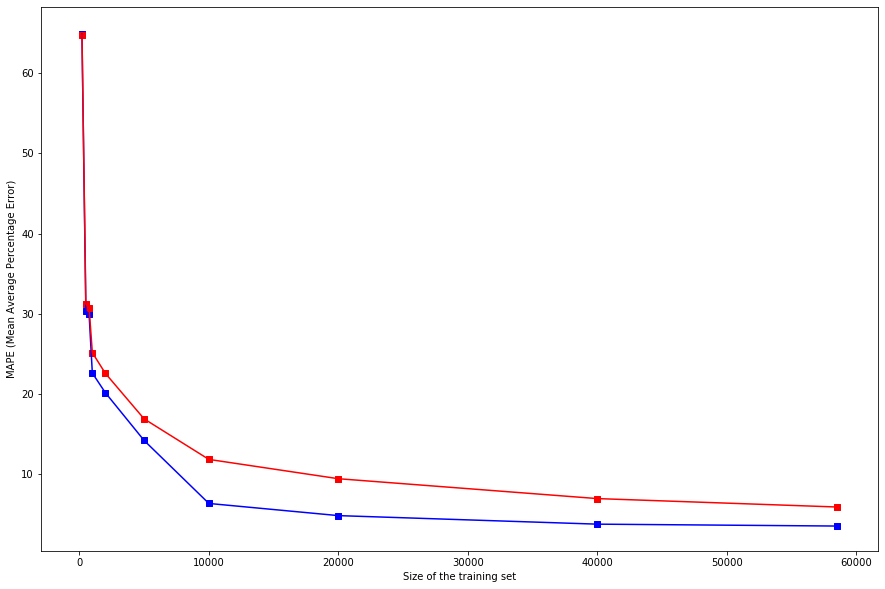

In [9]:
plt.figure(figsize =(15,10))
plt.scatter(df["size"], df["MAPE train"], color ="blue", marker = "s")
plt.plot(df["size"], df["MAPE train"], color ="blue")
plt.scatter(df["size"], df["MAPE test"], color ="red", marker = "s")
plt.plot(df["size"], df["MAPE test"], color ="red")
plt.xlabel("Size of the training set")
plt.ylabel("MAPE (Mean Average Percentage Error)")
plt.savefig("net_mape_training_size.png")
plt.show()